# Tracking centroids in succesive layers of k-means (hostility)

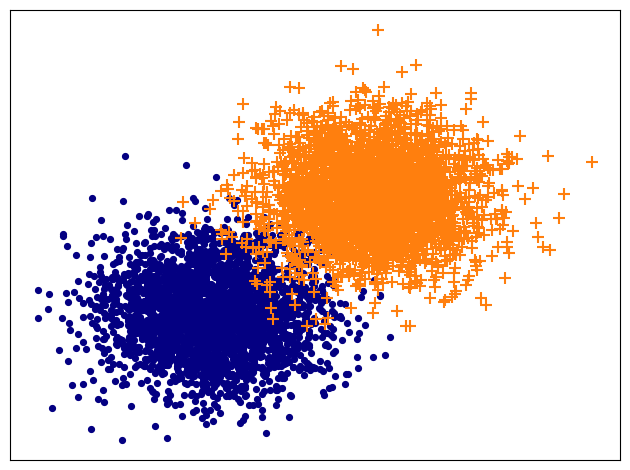

In [1]:

import pandas as pd
import copy
from sklearn import preprocessing
import numpy as np
from sklearn.cluster import KMeans
from Normal_dataset_generator import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from TrackingCentroidsMovement import *
from IPython.display import display

from sklearn.datasets import make_blobs, make_classification

In [2]:
import os
os.chdir("..")
root_path = os.getcwd()

Hacemos un minicambio en el algoritmo de la hostilidad para incluir como output los centroides en cada una de las capas. Esta versión se llama hostility_measure_Centroids().

Además, creamos una función llamada plot_hierarchical_quivers_with_complexity() (por ahora solo para 2D) que pinta cómo se van moviendo los centroides en las sucesivas capas y cómo va cambiando su hostilidad. Es un gráfico tipo mapa vectorial con tantos plots como número de capas -1 puesto que va mostrando la transición entre ellos. Las flechas están coloreadas mediante un degradado en función del cambio en la hostilidad (mayor hostilidad es malo y menor hostilidad es bueno) del cluster previo al cluster siguiente. Cada plot muestra el cambio entre una capa y la siguiente. Así, en cada gráfico, las flechas se inician en la posición previa de los puntos y finalizan en el centroide del cluster en el que acaban asignados en la siguiente capa. Recordemos que mediante el parámetro k_auto se seleccionaba de forma automática la última capa a tener en cuenta. Este parámetro también se le pasa a la función del plot del mapa vectorial para que solo se grafiquen aquellas capas aceptadas y evitar ruido.

Aclaramos que este gráfico se utilizará únicamente en 1D y 2D para ir evaluando de forma gráfica si la idea que tenemos de utilizar el movimiento de los centroides y el cambio en complejidad funciona o no. Así, sirve a modo exploratorio, ilustrativo e intuitivo.

### Ejemplo 1: Dos normales solapadas

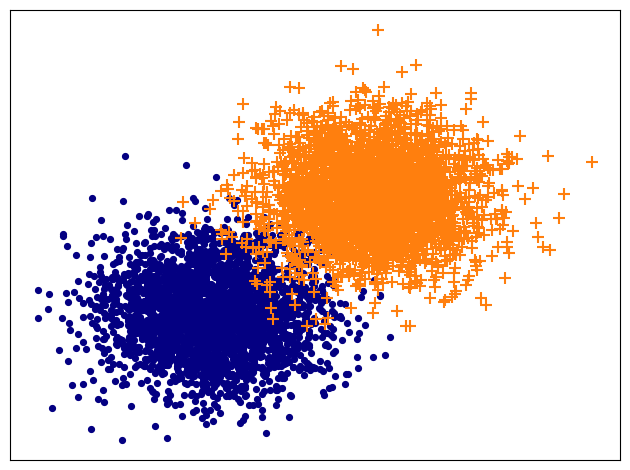

In [3]:
# Parameters
seed1 = 1
seed2 = 2
n0 = 3000
n1 = 3000

# Dataset 1
mu0 = [0, 0]
sigma0 = [[1, 0], [0, 1]]
mu1 = [3, 3]
sigma1 = [[1, 0], [0, 1]]

X, y = normal_generator2(mu0, sigma0, n0, mu1, sigma1, n1, seed1, seed2)

In [4]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(48)

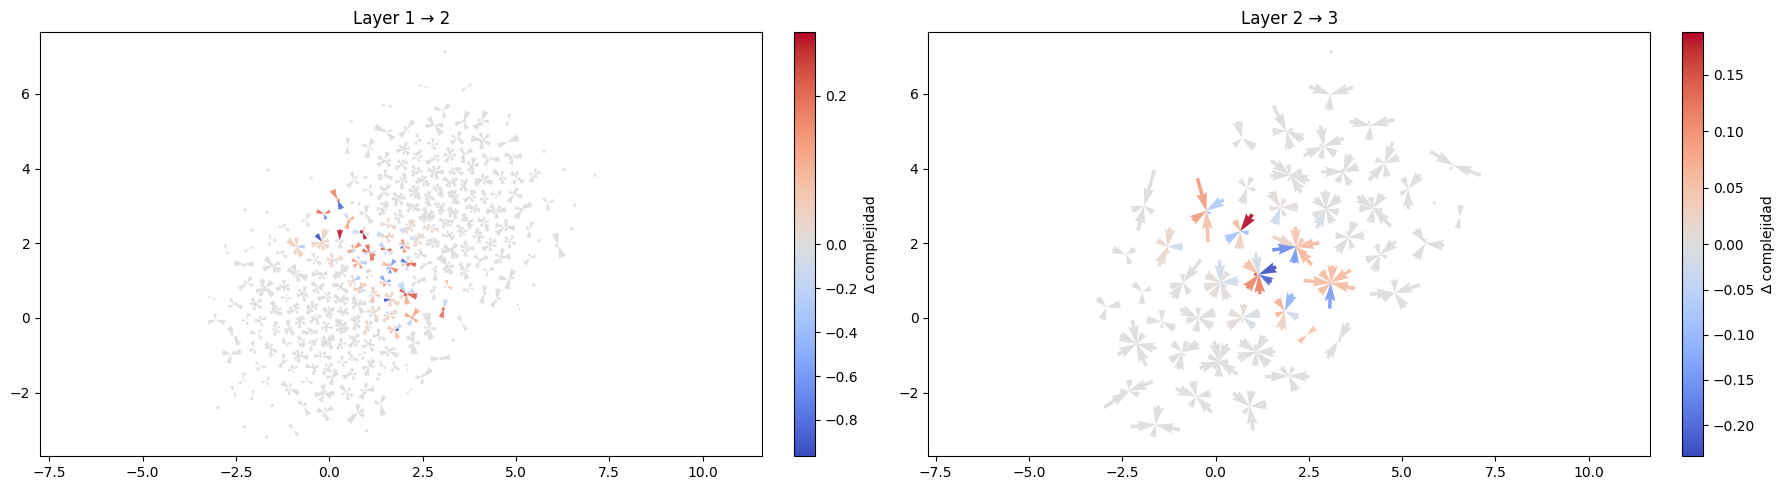

In [5]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=k_auto)

Observamos:
  * Primer gráfico. Movimientos muy pequeños (se pasa de puntos originales a primera tanda de centroides). Los únicos cambios de complejidad ocurren en puntos situados justo en el medio del gráfico. En el resto los cambios son aproximadamente 0.
  * Segundo gráfico. De nuevo, los únicos cambios ocurren en el centro de los datos. Se aprecia que alejarse de ese centro, disminuye la complejidad (flechas azules) y acercarse, aumenta la complejidad (flechas rojas).
  * Tercer gráfico. El patrón del segundo gráfico se vuelve a repetir pero ahora aun más claro.

Con esta visualización queda claro dónde está el lío y hacia donde es mejor moverse para minimizar la complejidad. Debería salir que ambas son importantes.

Ahora la idea es ver si podemos cuantificar correctamente la magnitud de dichos movimientos con respecto a cada dimensión y con ello elaborar un ranking de utilidad de las variables que nos permita hacer feature selection. “direccionalidad por feature” → es como un gradiente de complejidad en el espacio de variables.


## Primera idea ranking feature selection

1. Descomponer el vector de movimiento. Para cada transición de centroide, vamos a mirar la contribución de cada feature (magnitud del cambio en esa dimensión) y vamos a asociar dicha contribución con el incremento de complejidad que haya ocurrido.
2. Calcular un score por feature. Una primera puede ser:
$$score(f_j) = \sum_{layers\ l_i} \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i)$$ donde $f_j$ indica la variable $j$, es decir, la dimensión $j$. El producto nos diría si movernos en esa dimensión está relacionado con aumentar o reducir complejidad.
3. Realizar un ranking con el score. Si el score es siempre positivo (la hostilidad aumenta), entonces esa variable "empeora" la complejidad, es decir, dificulta la capacidad de discernir entre las clases y deberíamos "eliminarla". Por el contrario, si es negativo, quiere decir que esa variable contribuye a simplificar la estructura de los datos y es una buena candidata.


Comenzamos probando con 5 opciones de ranking:

1. Valor crudo (score_raw). Básicamente es $$score(f_j) = \sum_{layers\ l_i} \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i)$$, es decir, el resultado de ir sumando el cambio de complejidad multiplicada por la magnitud del cambio en la variable.
2. Valor normalizado para que el vector sume 1 y los resultados sean más interpretables. Simplemente es dividir cada valor final por la suma total de los elementos del vector.
3. Versión más robusta en la que además se multiplica por el número de puntos involucrados en cada cluster. Así, se intentaría "igual" el efecto que tienen las distintas capas. En las primeras capas, el número de clusters es más alta (es decir, se añaden más sumandos al score) pero el número de puntos en cada cluster es menor (¡ojo! porque los cambios en complejidad serán más chiquitines, o sea que quizás ya se está contemplando). Por otro lado, en las capas finales el número de clusters es más pequeño (es decir, se añaden pocos sumandos al score) pero la cantidad de puntos agrupado en cada cluster será mayor, así se ponderarán más dichos cambios (¡ojo! porque aquí los cambios en complejidad serán mayores y eso ya hará que tenga más impacto). Este score sería: $$score(f_j) = \sum_{layers\ l_i} \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i) \cdot |Centroid_j(l_i)|$$
4. Versión estandarizada. Nosotros vamos a trabajar con datos estandarizados, pero por si acaso, para evitar que una dimensión se lleve más peso simplemente por el hecho de ser más susceptible a movimientos, podemos hacer el siguiente ajuste: $$score(f_j) = \sum_{layers\ l_i} \frac{ \Delta Complexity(l_i) \cdot \Delta Centroid_j(l_i)}{|\sum \Delta Centroid_j(l_i)|}$$
 Cada dimensión se normaliza según cuánto se ha movido en total. Evita que una feature con centroides muy móviles domine aunque su relación con la complejidad sea débil. Es como un “efecto medio por unidad de movimiento en esa dimensión”. Normaliza cada feature respecto a su propio movimiento, para indicar cuánto cambio de complejidad genera por unidad de desplazamiento.
5. Combinación de estandarizada y robustez.


In [6]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=k_auto)

In [7]:
resultados

{'scores': {'raw': {0: -0.5134245339709695, 1: -0.15716810604376907},
  'normalized_simple': {0: -0.7656280479900365, 1: -0.23437195200996352},
  'robust': {0: -0.6442374129927235, 1: 4.448001396126758},
  'norm_by_movement': {0: -0.002790524253082417, 1: -0.000845708921939449},
  'robust_norm_by_movement': {0: -0.00029856957837791543,
   1: 0.0020638816278652646}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [0, 1],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([-0.56347708, -0.4041785 ]),
  array([0.05005255, 0.2470104 ])],
 'list_scores_robust': [array([-3.91732066, -3.24352012]),
  array([ 2.62884583, 12.13952292])],
 'list_scores_centroid_mean_range': [array([0.3150014, 0.2547187]),
  array([0.36599144, 0.28126953])],
 'list_scores_centroid_sum_range': [array([378.00167538, 305.66244388]),
  array([87.83794577, 67.50468759])],
 'list_scores_centroid_mean_iqr': [array([0.93844309, 0.91529781]),
  array([0.

Por ahora nos fijamos en el ranking raw y lo que vemos es que indica que ambas variables aportan de cara a disminuir la complejidad (ambos score son negativos). El score de x es mayor en valor absoluto que el de y, lo que indicaría que la variable x ayuda más a minimizar la complejidad que la y. Visualmente se aprecia que un corte en x es más discriminante que un corte en y. A los otros scores por ahora no les veo chicha.

In [8]:
resultados['details']

,layer_from,cluster_from,cluster_to,n_points,comp_old,comp_new,change_comp,change_0,change_1
0,1,0.0,67,2,0.0,0.090909,0.090909,0.115690,0.088702
1,1,1.0,128,5,0.0,0.000000,0.000000,0.020066,0.078902
2,1,2.0,169,10,0.0,0.000000,0.000000,0.058173,0.176287
3,1,3.0,205,8,0.0,0.071429,0.071429,0.138172,0.127242
4,1,4.0,236,11,0.0,0.000000,0.000000,0.107658,0.175940
...,...,...,...,...,...,...,...,...,...
1435,2,235.0,37,56,0.0,0.000000,0.000000,0.078672,0.019144
1436,2,236.0,39,53,0.0,0.000000,0.000000,0.024164,0.164279
1437,2,237.0,11,2,0.0,0.000000,0.000000,0.242151,0.007217
1438,2,238.0,27,8,0.0,0.000000,0.000000,0.113881,0.645336


In [9]:
def make_synthetic_datasets(n_samples=3000, random_state=42):
    rng = np.random.RandomState(random_state)
    datasets = {}

    # --- 1. 1D en 2D (y = 0 siempre)
    x = np.concatenate([rng.normal(-3, 1, n_samples//2), rng.normal(3, 1, n_samples//2)])
    y = np.zeros_like(x)
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["1D_x_active"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 2. 1D en 2D (x = 0 siempre)
    y = np.concatenate([rng.normal(-3, 1, n_samples//2), rng.normal(3, 1, n_samples//2)])
    x = np.zeros_like(y)
    datasets["1D_y_active"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 3. 2 blobs bien separados
    X, l = make_blobs(n_samples=n_samples, centers=[(0,0),(5,5)], random_state=rng)
    datasets["2D_blobs"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "label": l})

    # --- 4. Relevancia desigual (x discrimina, y ruido)
    x = np.concatenate([rng.normal(0, 1, n_samples//2), rng.normal(5, 1, n_samples//2)])
    y = rng.normal(0, 5, n_samples)
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["2D_x_relevant"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 5. XOR
    # Generamos puntos en [-4,4]×[-4,4]
    x = rng.uniform(low=-4, high=4, size=(2000,2))
    # Etiquetas XOR
    sx = (x[:,0] > 0).astype(int)
    sy = (x[:,1] > 0).astype(int)
    # XOR clásico
    y = np.bitwise_xor(sx, sy)
    datasets["2D_XOR"] = pd.DataFrame({"0": x[:,0],"1": x[:,1],"label": y})

    # --- 6. 3D con redundancia (z = x)
    X, l = make_blobs(n_samples=n_samples, centers=[(0,0),(5,5)], random_state=rng)
    z = X[:,0].copy()
    datasets["3D_redundant"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "2": z, "label": l})

    # --- 7. Concéntricos
    angles = rng.uniform(0, 2*np.pi, n_samples)
    radii = np.concatenate([rng.normal(1, 0.1, n_samples//2), rng.normal(3, 0.1, n_samples//2)])
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["2D_circles"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 8. Elipses (misma media, distinta varianza)
    x = np.concatenate([rng.normal(0, 1, n_samples//2), rng.normal(0, 5, n_samples//2)])
    y = np.concatenate([rng.normal(0, 5, n_samples//2), rng.normal(0, 1, n_samples//2)])
    labels = np.array([0]*(n_samples//2) + [1]*(n_samples//2))
    datasets["2D_ellipses"] = pd.DataFrame({"0": x, "1": y, "label": labels})

    # --- 9. Clusters con distinto tamaño
    X1, l1 = make_blobs(n_samples=n_samples//4, centers=[(0,0)], cluster_std=0.5, random_state=rng)
    X2, l2 = make_blobs(n_samples=3*n_samples//4, centers=[(5,5)], cluster_std=1.5, random_state=rng)
    X = np.vstack([X1, X2])
    l = np.array([0]*(n_samples//4) + [1]*(3*n_samples//4))
    datasets["2D_unbalanced"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "label": l})

    # --- 10. Aleatorio puro (sin estructura)
    X = rng.uniform(-5, 5, size=(n_samples, 2))
    datasets["2D_random"] = pd.DataFrame({"0": X[:,0], "1": X[:,1], "label": rng.randint(0,2,n_samples)})

    return datasets

In [10]:
datasets = make_synthetic_datasets()

## Dataset 1: 1D con y inactiva

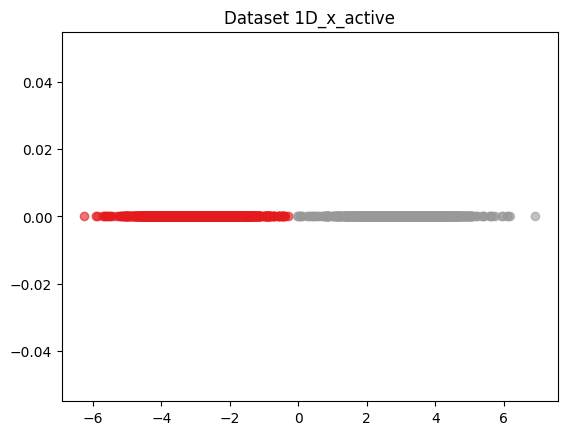

In [11]:
datasets["1D_x_active"]
df = datasets["1D_x_active"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 1D_x_active")
plt.show()

In [12]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["1D_x_active"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["1D_x_active"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(600)

In [13]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.001333,0.002000,0.001333,0.000667,0.001000
120,0.001333,0.008667,0.001333,0.000000,0.000667
24,0.001333,0.030667,0.001333,0.000000,0.000667
4,0.001333,0.752000,0.001333,0.000000,0.000667


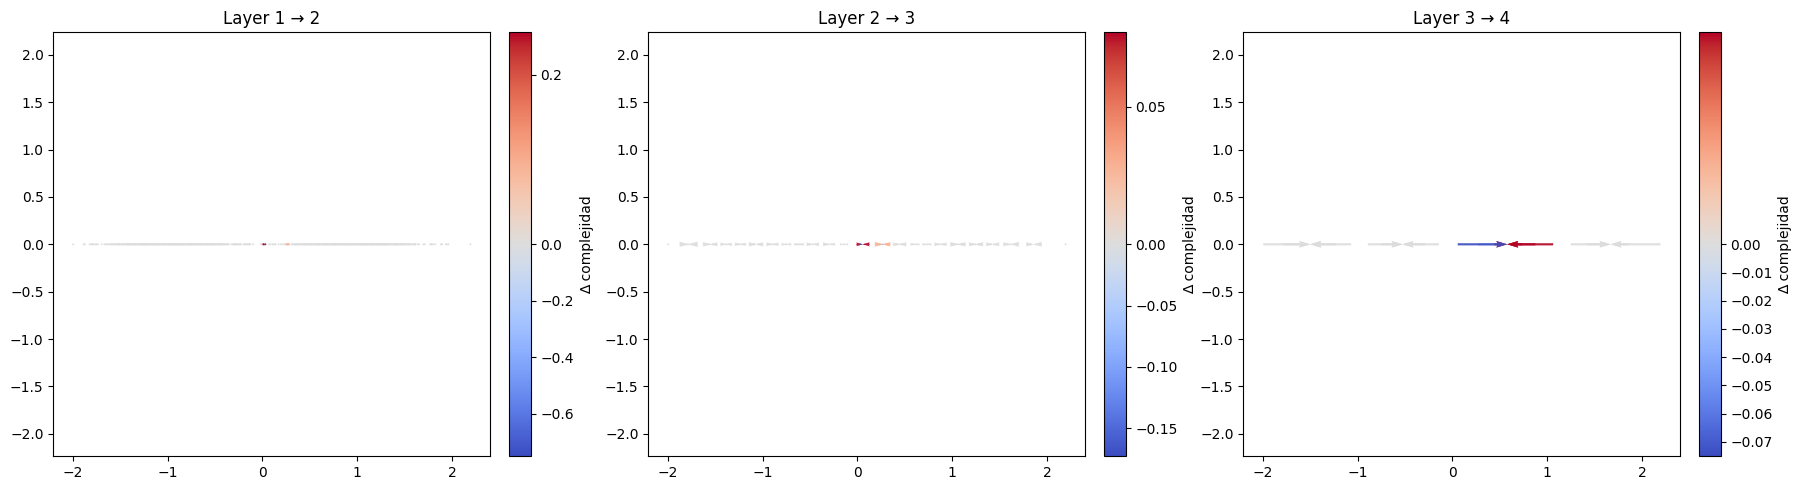

In [14]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

In [15]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)

/home/carmen/PycharmProjects/FeatureSelection_Complexity/TrackingCentroidsMovement.py:552: RuntimeWarning: invalid value encountered in divide
  norm_mov_vec = vec / mov if np.any(mov > 0) else vec


In [16]:
resultados['scores']

{'raw': {0: -0.02721737319234669, 1: 0.0},
 'normalized_simple': {0: -1.0, 1: 0.0},
 'robust': {0: -0.19685470462599414, 1: 0.0},
 'norm_by_movement': {0: -0.0017591294484871722, 1: nan},
 'robust_norm_by_movement': {0: -0.00019881895901281544, 1: nan}}

Vemos que el score de la variable y que permanece inactiva es siempre 0 y el de la variable x es negativo, lo que indica que es útil para reducir la complejidad.
De la capa 1 a la capa 2 vemos que sale que aumenta la complejidad pero es un valor realmente despreciable.

In [17]:
resultados

{'scores': {'raw': {0: -0.02721737319234669, 1: 0.0},
  'normalized_simple': {0: -1.0, 1: 0.0},
  'robust': {0: -0.19685470462599414, 1: 0.0},
  'norm_by_movement': {0: -0.0017591294484871722, 1: nan},
  'robust_norm_by_movement': {0: -0.00019881895901281544, 1: nan}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [0, 1],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([0.00447872, 0.        ]),
  array([0.01391542, 0.        ]),
  array([-0.04561151,  0.        ])],
 'list_scores_robust': [array([0.0046714, 0.       ]),
  array([0.10968827, 0.        ]),
  array([-0.50806908,  0.        ])],
 'list_scores_centroid_mean_range': [array([0.27107442, 0.        ]),
  array([0.40792755, 0.        ]),
  array([0.53454554, 0.        ])],
 'list_scores_centroid_sum_range': [array([162.64465213,   0.        ]),
  array([48.95130656,  0.        ]),
  array([12.82909297,  0.        ])],
 'list_scores_centroid_mean_iqr': [arr

Estandarizar con z (tipo normal) no funciona bien, lo ordena al revés. Tiene sentido porque son datos en 2D y está asumiendo una normal.

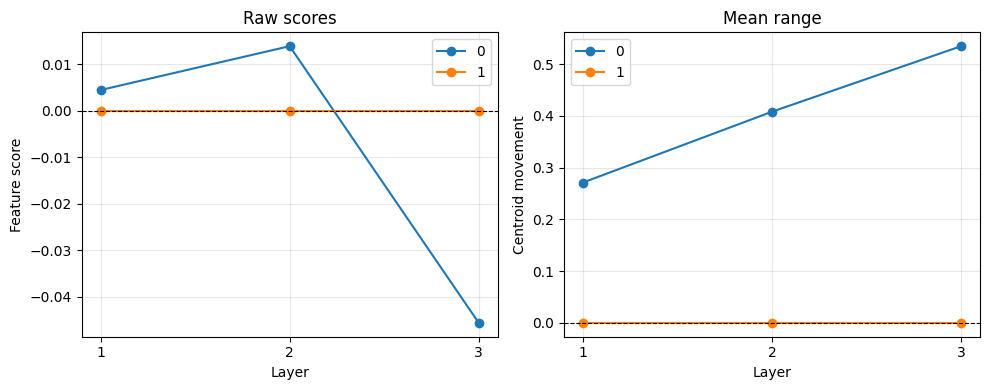

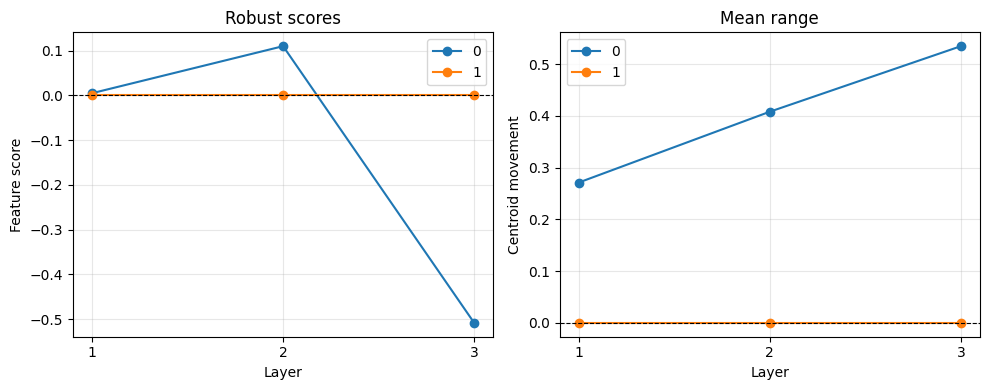

In [18]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')


In [19]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,0.004479,0.013915,-0.045612
1,0.000000,0.000000,0.000000


Centroids movement


layer,1,2,3
feature,,,
0,0.271074,0.407928,0.534546
1,0.000000,0.000000,0.000000


Aquí vemos claramente que la variable y vale siempre 0, tanto en complejidad como en movimiento de centroide. La variable x disminuye la complejidad y es la que marca el movimiento.

## Dataset 2: 1D x inactiva

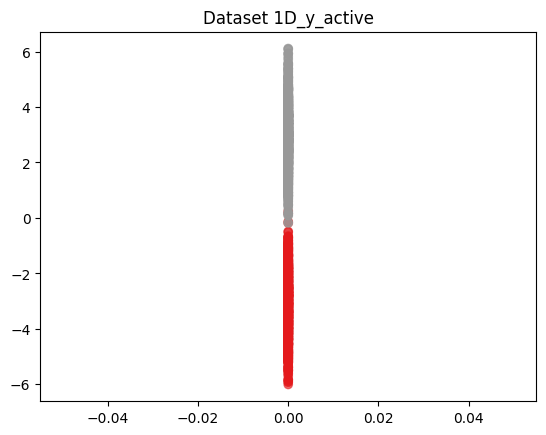

In [20]:
df = datasets["1D_y_active"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 1D_y_active")
plt.show()

In [21]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["1D_y_active"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["1D_y_active"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(120)

In [22]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.002000,0.004000,0.002000,0.000667,0.001333
120,0.002667,0.005333,0.002000,0.000667,0.001333
24,0.002667,0.005333,0.002000,0.000000,0.001000
4,0.002667,0.458667,0.002667,0.000000,0.001333


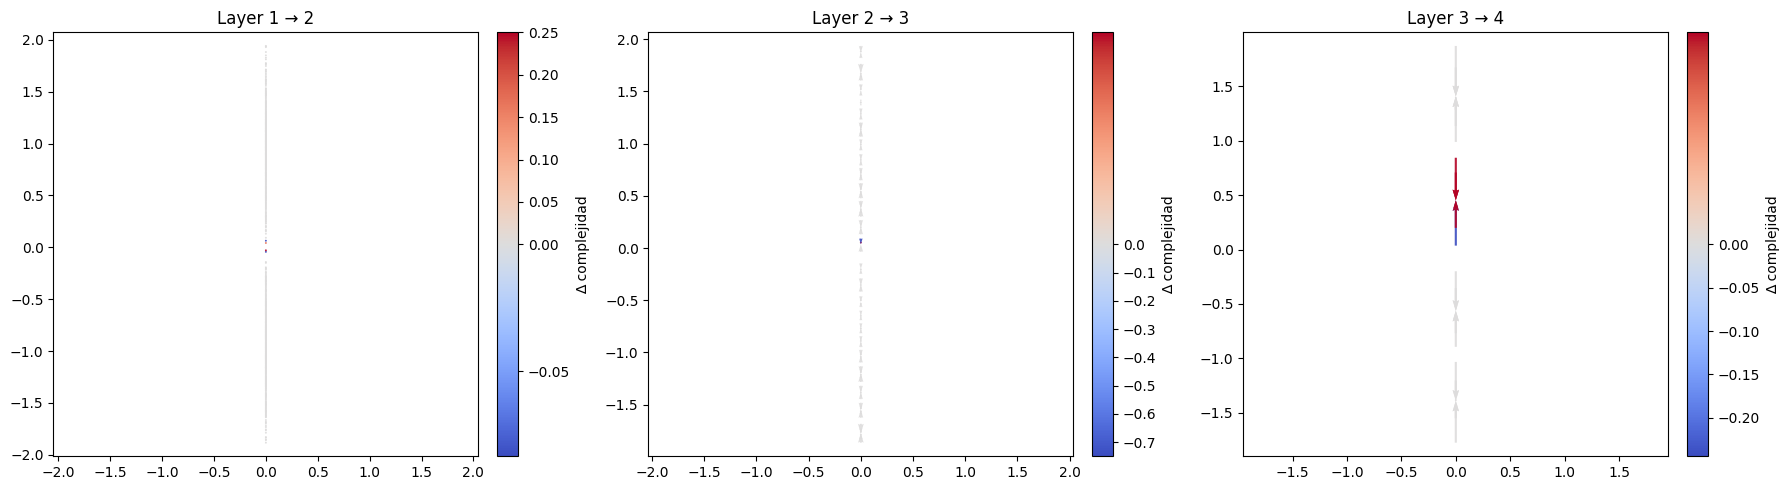

In [23]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

In [24]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

/home/carmen/PycharmProjects/FeatureSelection_Complexity/TrackingCentroidsMovement.py:552: RuntimeWarning: invalid value encountered in divide
  norm_mov_vec = vec / mov if np.any(mov > 0) else vec


{'raw': {0: 0.0, 1: -0.13401836548578913},
 'normalized_simple': {0: 0.0, 1: -1.0},
 'robust': {0: 0.0, 1: -0.29009055233087067},
 'norm_by_movement': {0: nan, 1: -0.009488835211532739},
 'robust_norm_by_movement': {0: nan, 1: -0.00034308279197068503}}

In [25]:
resultados

{'scores': {'raw': {0: 0.0, 1: -0.13401836548578913},
  'normalized_simple': {0: 0.0, 1: -1.0},
  'robust': {0: 0.0, 1: -0.29009055233087067},
  'norm_by_movement': {0: nan, 1: -0.009488835211532739},
  'robust_norm_by_movement': {0: nan, 1: -0.00034308279197068503}},
 'rankings': {'raw': [1, 0],
  'normalized_simple': [1, 0],
  'robust': [1, 0],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([0.        , 0.00211563]),
  array([ 0.        , -0.04047211]),
  array([ 0.        , -0.09566188])],
 'list_scores_robust': [array([ 0.00000000e+00, -1.73472348e-18]),
  array([ 0.        , -0.15081477]),
  array([ 0.        , -0.42936634])],
 'list_scores_centroid_mean_range': [array([0.        , 0.35709181]),
  array([0.        , 0.41768914]),
  array([0.        , 0.49864294])],
 'list_scores_centroid_sum_range': [array([  0.        , 214.25508791]),
  array([ 0.        , 50.12269651]),
  array([ 0.        , 11.96743045])],
 'list_scores_centroid_

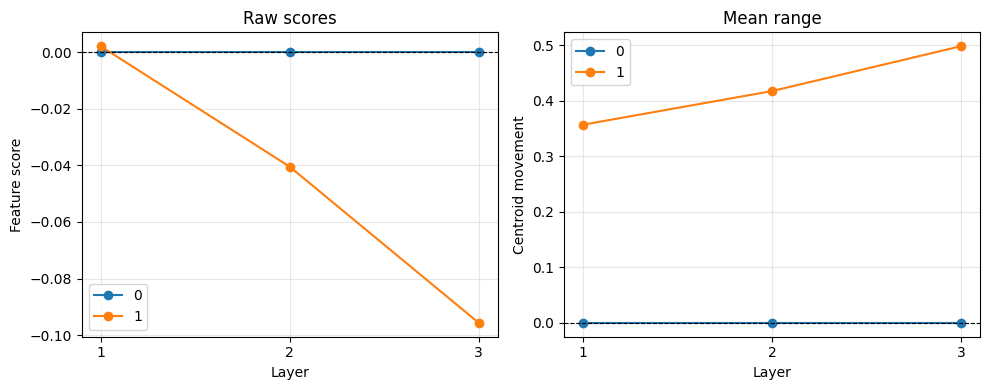

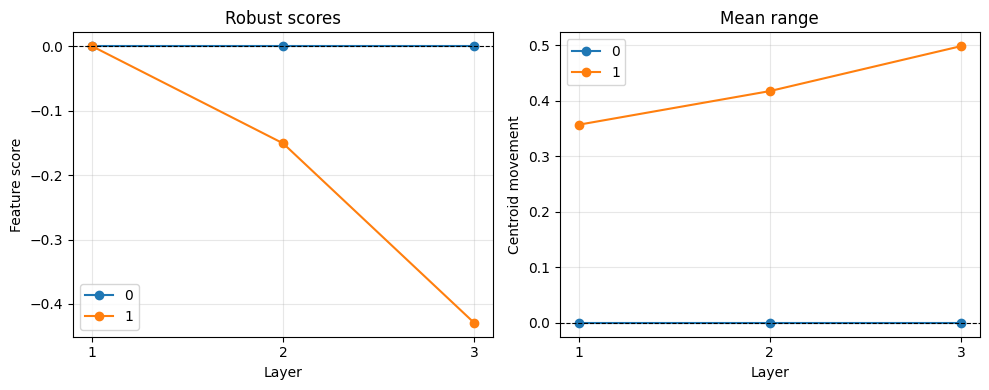

In [26]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [27]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,0.000000,0.000000,0.000000
1,0.002116,-0.040472,-0.095662


Centroids movement


layer,1,2,3
feature,,,
0,0.000000,0.000000,0.000000
1,0.357092,0.417689,0.498643


Con la x inactiva vemos que el comportamiento también es el esperado: la variable x no aporta nada y la variable y ayuda a minimizar la complejidad.

## Dataset 3: Normales separadas en 2D

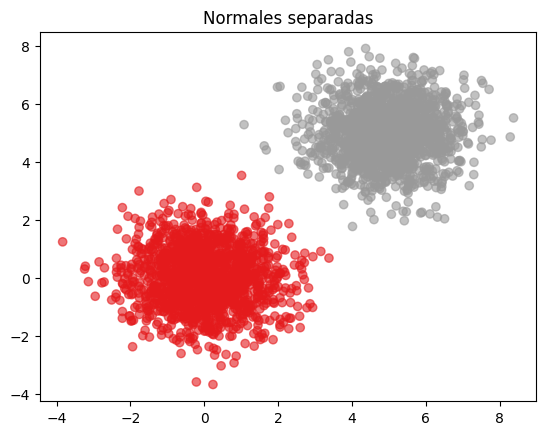

In [28]:
df = datasets["2D_blobs"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [29]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [30]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.000000,0.000000,0.0,0.0,0.0
120,0.000000,0.000000,0.0,0.0,0.0
24,0.006000,0.000667,0.0,0.0,0.0
4,0.566667,0.000667,0.0,0.0,0.0


In [31]:
# plot_hierarchical_quivers_with_complexity(
#     data_clusters,
#     centroids_dict,
#     host_instance_by_layer_df,
#     delta=0.5,
#     k_auto=4)
# como todo es 0, no se pinta

In [32]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: 0.0, 1: 0.0},
 'normalized_simple': {0: 0.0, 1: 0.0},
 'robust': {0: 0.0, 1: 0.0},
 'norm_by_movement': {0: 0.0, 1: 0.0},
 'robust_norm_by_movement': {0: 0.0, 1: 0.0}}

In [33]:
resultados

{'scores': {'raw': {0: 0.0, 1: 0.0},
  'normalized_simple': {0: 0.0, 1: 0.0},
  'robust': {0: 0.0, 1: 0.0},
  'norm_by_movement': {0: 0.0, 1: 0.0},
  'robust_norm_by_movement': {0: 0.0, 1: 0.0}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [0, 1],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([0., 0.]), array([0., 0.]), array([0., 0.])],
 'list_scores_robust': [array([0., 0.]), array([0., 0.]), array([0., 0.])],
 'list_scores_centroid_mean_range': [array([0.29877086, 0.26831985]),
  array([0.34247734, 0.32957715]),
  array([0.37364327, 0.41559772])],
 'list_scores_centroid_sum_range': [array([179.2625183 , 160.99191059]),
  array([41.09728085, 39.54925833]),
  array([8.96743856, 9.97434536])],
 'list_scores_centroid_mean_iqr': [array([0.98034347, 0.95974515]),
  array([1.13633085, 0.98132451]),
  array([1.03787887, 1.35460351])],
 'list_scores_centroid_sum_iqr': [array([588.20608262, 575.84709126]),
  array([1

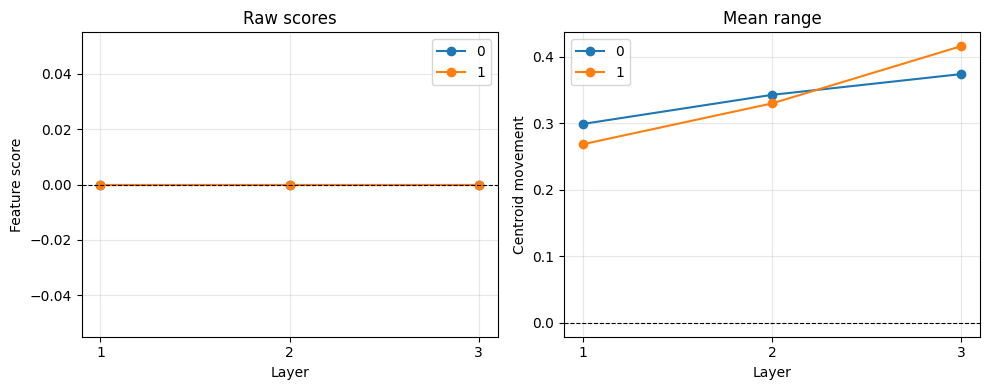

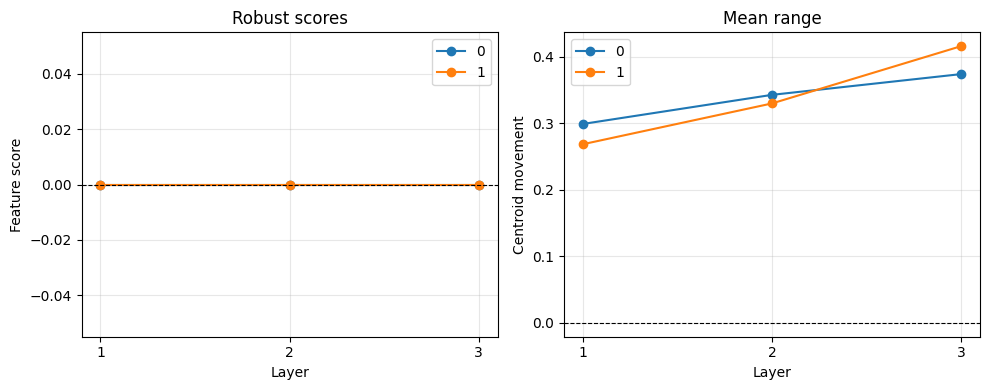

In [34]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [35]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0


Centroids movement


layer,1,2,3
feature,,,
0,0.298771,0.342477,0.373643
1,0.268320,0.329577,0.415598


Aquí tenemos un "problema": como la complejidad es 0 al ser clases totalmente separadas, no se llega a sacar información de qué variable es más discriminante. ¿Qué pasa si hay otra redundante? Lo estudiamos a continuación con el dataset 4 (que realmente es el 6 en la creación de datasets).

Al sacar la info del movimiento de los centroides yo sí creo que se aclaran las cosas. Se ve que ambos se mueven de forma similar, lo que pasa es que la complejidad es 0. Tiene mucho empate el ranking, hay que darle flexibilidad.

Sale que las 2 aportan más o menos lo mismo. En el límite, si son iguales (correlación = 1), una sobra, aquí digamos que una sobra parcialmente. Con las 2 se llega a complejidad 0 y con 1 tendríamos una complejidad bajita. En un problema de regresión lineal, evitaríamos juntar estas 2 variables, o sea que los resultados van yendo bien.

## Dataset 4: 2 normales separadas + 1 variable rendundante

Estudiamos ahora el caso previo pero añadiendo una variable redundante.

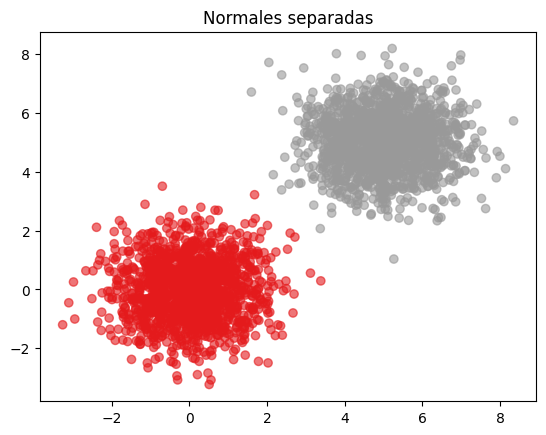

In [36]:
df = datasets["3D_redundant"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [37]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [38]:
# plot_hierarchical_quivers_with_complexity(
#     data_clusters,
#     centroids_dict,
#     host_instance_by_layer_df,
#     delta=0.5,
#     k_auto=4)
# como todo es 0, no se pinta

In [39]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: 0.0, 1: 0.0, 2: 0.0},
 'normalized_simple': {0: 0.0, 1: 0.0, 2: 0.0},
 'robust': {0: 0.0, 1: 0.0, 2: 0.0},
 'norm_by_movement': {0: 0.0, 1: 0.0, 2: 0.0},
 'robust_norm_by_movement': {0: 0.0, 1: 0.0, 2: 0.0}}

In [40]:
resultados

{'scores': {'raw': {0: 0.0, 1: 0.0, 2: 0.0},
  'normalized_simple': {0: 0.0, 1: 0.0, 2: 0.0},
  'robust': {0: 0.0, 1: 0.0, 2: 0.0},
  'norm_by_movement': {0: 0.0, 1: 0.0, 2: 0.0},
  'robust_norm_by_movement': {0: 0.0, 1: 0.0, 2: 0.0}},
 'rankings': {'raw': [0, 1, 2],
  'normalized_simple': [0, 1, 2],
  'robust': [0, 1, 2],
  'norm_by_movement': [0, 1, 2],
  'robust_norm_by_movement': [0, 1, 2]},
 'list_scores_raw': [array([0., 0., 0.]),
  array([0., 0., 0.]),
  array([0., 0., 0.])],
 'list_scores_robust': [array([0., 0., 0.]),
  array([0., 0., 0.]),
  array([0., 0., 0.])],
 'list_scores_centroid_mean_range': [array([0.29715216, 0.30296268, 0.29715216]),
  array([0.40880923, 0.35200206, 0.40880923]),
  array([0.41688059, 0.51350622, 0.41688059])],
 'list_scores_centroid_sum_range': [array([178.2912933 , 181.77760644, 178.2912933 ]),
  array([49.05710766, 42.24024771, 49.05710766]),
  array([10.00513422, 12.32414937, 10.00513422])],
 'list_scores_centroid_mean_iqr': [array([0.93740228, 0

Tiene todo el sentido del mundo porque cuando tengo una situación como la del siguiente gráfico en la que dos variables son exactamente iguales, básicamente proyectar sobre una u otra me da la misma información puesto que una es redudante. No obstante, los clusters se van a mover por la línea diagonal. Entonces no es que tengamos que buscar movimiento 0 (los clusters se van a mover por la diagonal), lo que tenemos que buscar es moviento equivalente, con correlación alta. Y luego complementar esto con la complejidad a ver a qué vamos llegando.

¡OJO! Porque con el ewkm salía también el mismo comportamiento, o sea que podemos regresar a dicha idea.

Otro problema puede ser el tema de curse of dimensionality porque estamos usando k-means y dist. euclídea. Pero puede ser interesante comenzar probando hasta dónde llegamos con este método. O sea, primero probar si es válido. En caso de que sea válido, ver hasta qué número de dimensiones es útil.

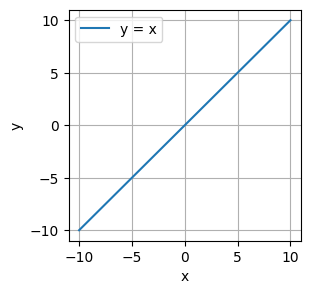

In [41]:
# Datos
x = np.linspace(-10, 10, 200)
y = x

# Gráfico
plt.figure(figsize=(3,3))
plt.plot(x, y, label="y = x")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

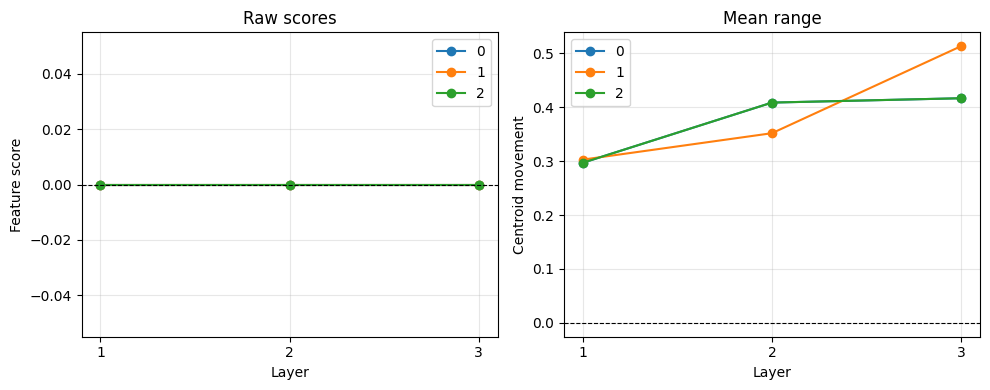

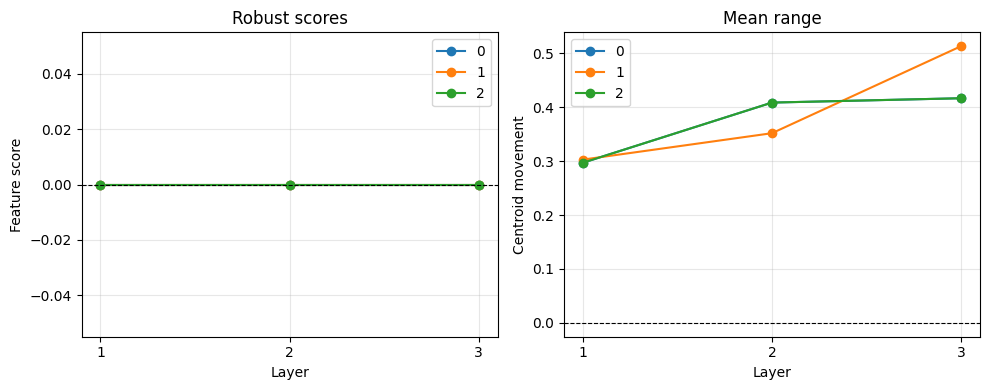

In [42]:
feature_cols = ["0", "1",'2']
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [43]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0


Centroids movement


layer,1,2,3
feature,,,
0,0.297152,0.408809,0.416881
1,0.302963,0.352002,0.513506
2,0.297152,0.408809,0.416881


Claramente hay 2 variables idénticas y la tercera es "similar" a las 2 iguales.

## Dataset 5: Normales, x discrimina, y ruido

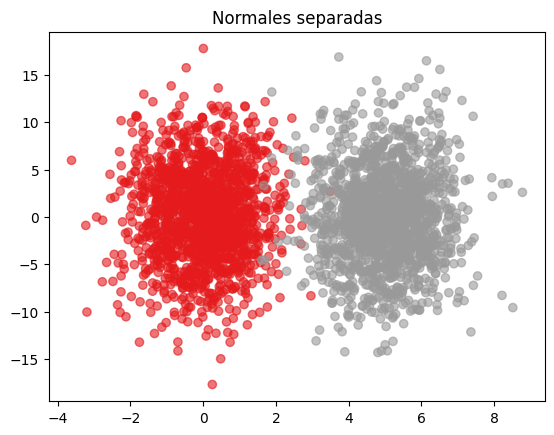

In [44]:
df = datasets["2D_x_relevant"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [45]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(120)

In [46]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.019333,0.015333,0.004667,0.007333,0.006000
120,0.096667,0.066667,0.004000,0.006667,0.005333
24,0.598667,0.417333,0.008000,0.006667,0.007333
4,1.000000,1.000000,0.008667,0.006667,0.007667


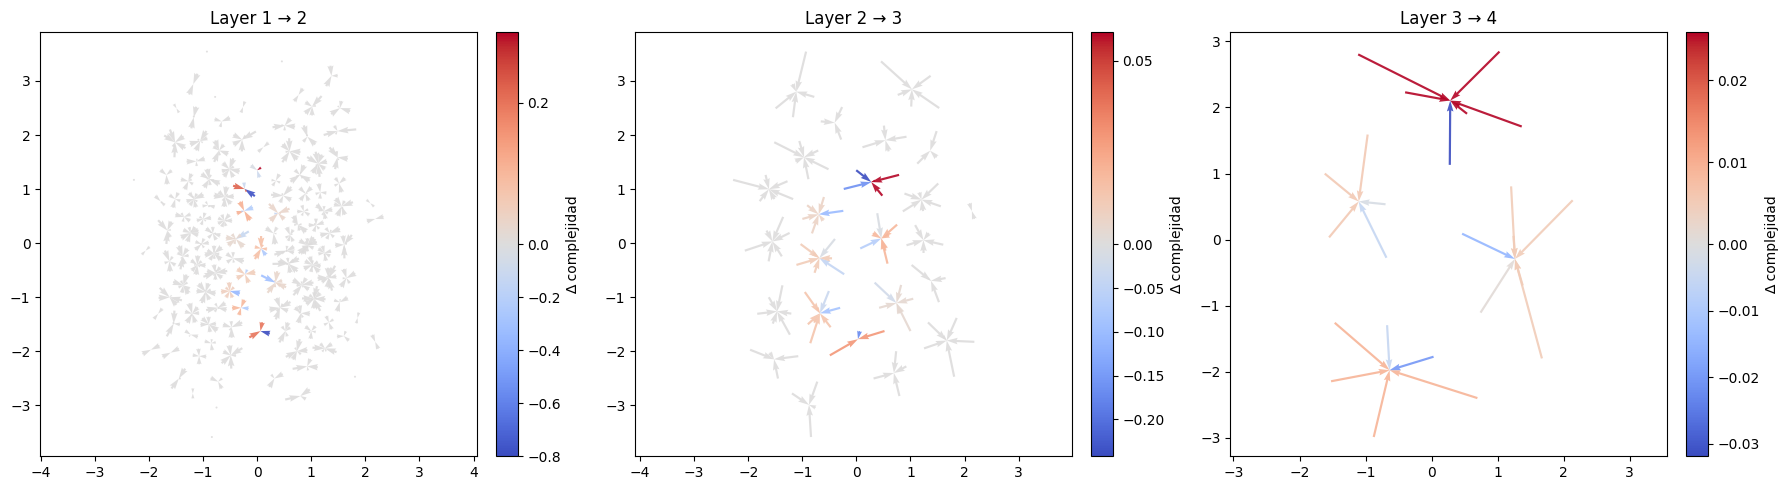

In [47]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

Claramente irte hacia el centro empeora e irte hacia fuera mejora. La última capa realmente sobra, ya no queda tan claro.

In [48]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: -0.3193920135306404, 1: -0.017646711830238502},
 'normalized_simple': {0: -0.9476418865181039, 1: -0.05235811348189607},
 'robust': {0: 1.444033125460463, 1: 0.645607305837648},
 'norm_by_movement': {0: -0.0033771662522705053, 1: -0.00018299537342295635},
 'robust_norm_by_movement': {0: 0.0006920932551509685,
  1: 0.00023535707439621372}}

In [49]:
resultados

{'scores': {'raw': {0: -0.3193920135306404, 1: -0.017646711830238502},
  'normalized_simple': {0: -0.9476418865181039, 1: -0.05235811348189607},
  'robust': {0: 1.444033125460463, 1: 0.645607305837648},
  'norm_by_movement': {0: -0.0033771662522705053, 1: -0.00018299537342295635},
  'robust_norm_by_movement': {0: 0.0006920932551509685,
   1: 0.00023535707439621372}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [1, 0],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [1, 0]},
 'list_scores_raw': [array([-0.27122684, -0.00930695]),
  array([-0.17101589, -0.06924178]),
  array([0.12285072, 0.06090202])],
 'list_scores_robust': [array([-1.43019537, -0.04738632]),
  array([0.6638478 , 2.21454063]),
  array([ 3.65441383, -0.8759397 ])],
 'list_scores_centroid_mean_range': [array([0.25854195, 0.32292083]),
  array([0.35289935, 0.31643424]),
  array([0.3869577 , 0.41690283])],
 'list_scores_centroid_sum_range': [array([155.12517164, 193.7524985 ]),
  array

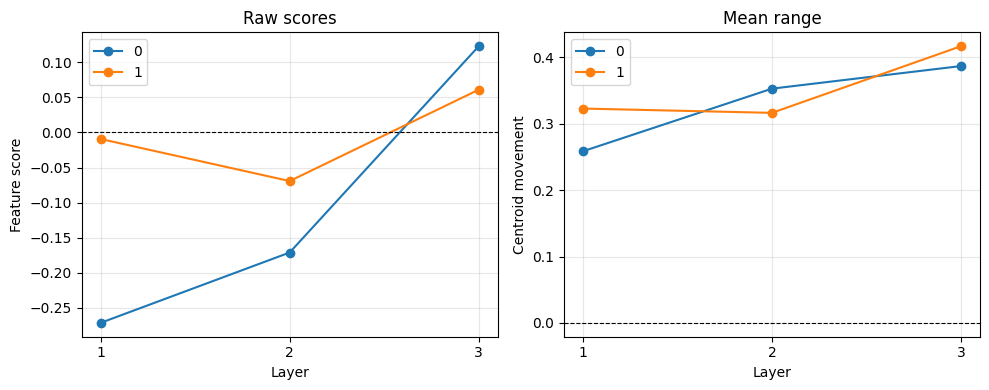

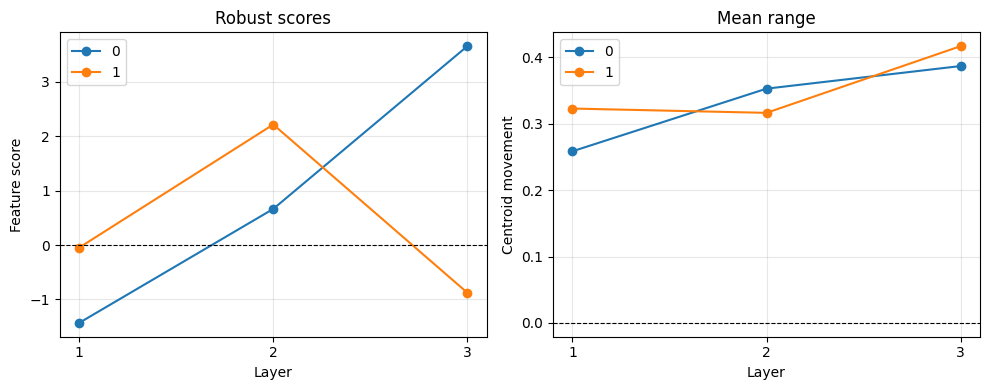

In [50]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [51]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,-0.271227,-0.171016,0.122851
1,-0.009307,-0.069242,0.060902


Centroids movement


layer,1,2,3
feature,,,
0,0.258542,0.352899,0.386958
1,0.322921,0.316434,0.416903


El ranking de complejidad ordena correctamente las variables pero también le da algo de puntos a la variable y.- Aunque sí distingue que es mejor la x que la y. La última capa sobra claramente.

El ranking de movimiento de los centroides confunde porque le da el mismo movimiento a las dos variables y claramente hay una más discriminante.

## Dataset 6: XOR

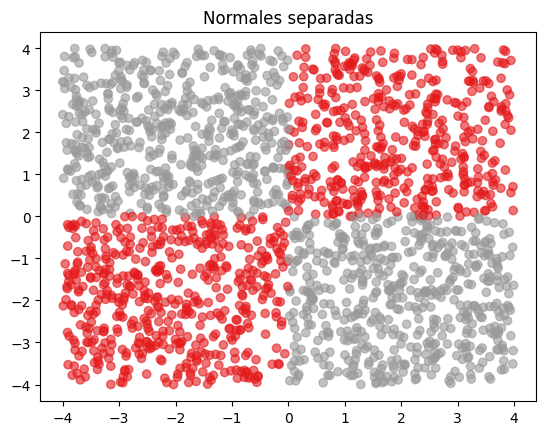

In [52]:
df = datasets["2D_XOR"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Normales separadas")
plt.show()

In [53]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(16)

In [54]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
400,0.057264,0.063387,0.027572,0.020814,0.024
80,0.135737,0.219489,0.022269,0.017975,0.020
16,0.531283,0.466414,0.029692,0.018921,0.024
3,1.000000,1.000000,0.034995,0.019868,0.027


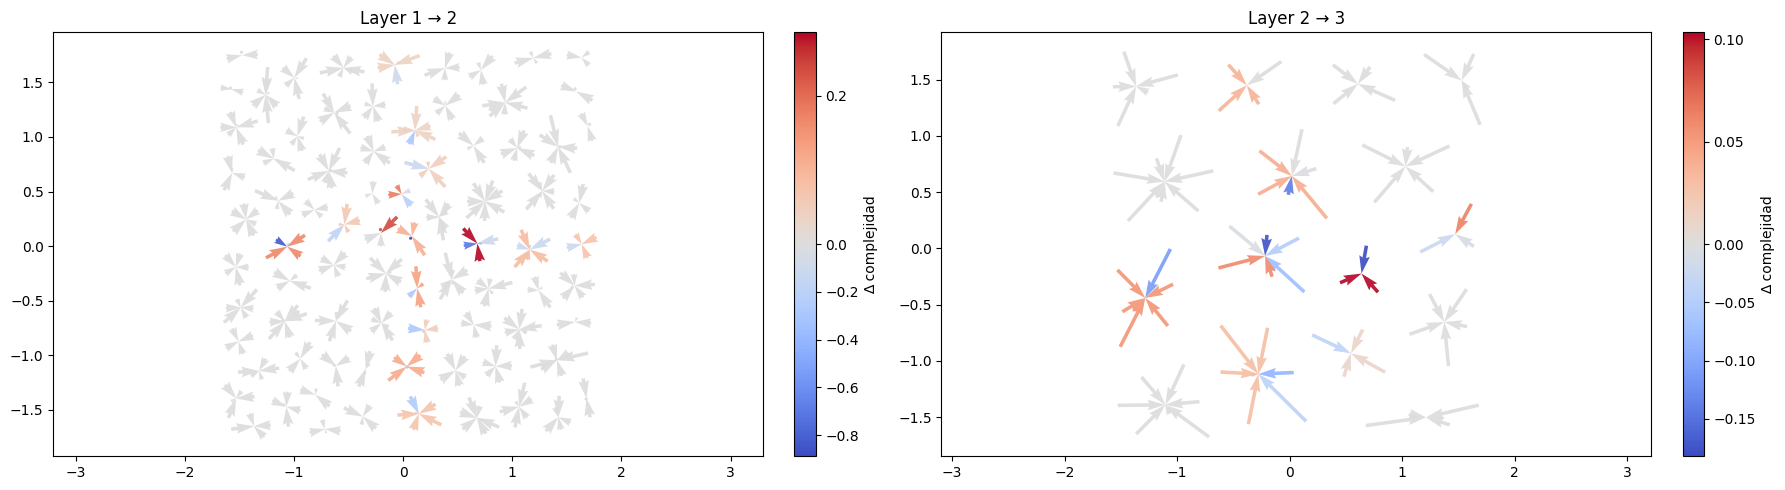

In [55]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=16)

El último gráfico claramente sobra. Visualmente el primer gráfico tampoco aclara mucho.

In [56]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=16)
resultados['scores']

{'raw': {0: 0.08983028052464456, 1: 0.20015486774763433},
 'normalized_simple': {0: 0.3097754525011027, 1: 0.6902245474988973},
 'robust': {0: 2.1459350900966343, 1: 1.7999066250928475},
 'norm_by_movement': {0: 0.0016665845213058176, 1: 0.003892055037691722},
 'robust_norm_by_movement': {0: 0.0033684187746252326,
  1: 0.003005491046608328}}

In [57]:
resultados

{'scores': {'raw': {0: 0.08983028052464456, 1: 0.20015486774763433},
  'normalized_simple': {0: 0.3097754525011027, 1: 0.6902245474988973},
  'robust': {0: 2.1459350900966343, 1: 1.7999066250928475},
  'norm_by_movement': {0: 0.0016665845213058176, 1: 0.003892055037691722},
  'robust_norm_by_movement': {0: 0.0033684187746252326,
   1: 0.003005491046608328}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [1, 0],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [1, 0]},
 'list_scores_raw': [array([0.01825049, 0.1888179 ]),
  array([0.07157979, 0.01133697])],
 'list_scores_robust': [array([-0.804594  ,  1.60676439]),
  array([5.09646418, 1.99304886])],
 'list_scores_centroid_mean_range': [array([0.31751624, 0.30438509]),
  array([0.43349841, 0.46008216])],
 'list_scores_centroid_sum_range': [array([127.0064974 , 121.75403743]),
  array([34.67987269, 36.80657304])],
 'list_scores_centroid_mean_iqr': [array([0.92615821, 0.99914288]),
  array([1.10544497, 

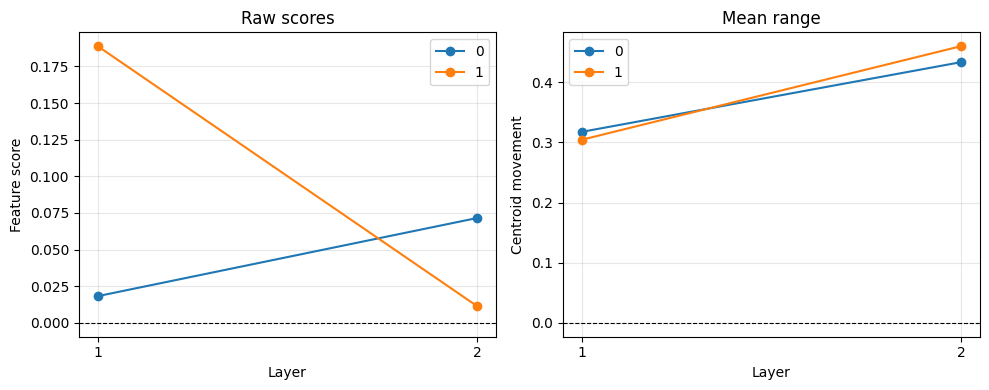

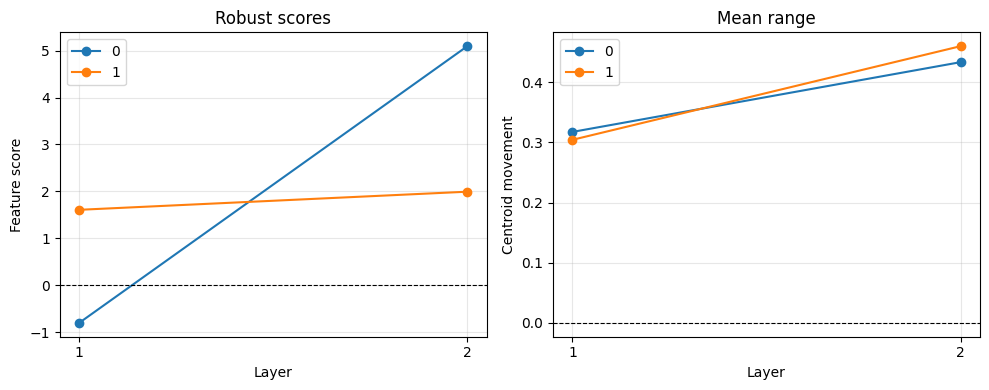

In [58]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [59]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2
feature,,
0,0.018250,0.071580
1,0.188818,0.011337


Centroids movement


layer,1,2
feature,,
0,0.317516,0.433498
1,0.304385,0.460082


El movimiento de los centroides indica claramente que ambas variables aportan similar. El tema de la complejidad está un poco loco, no queda claro en qué dirección es mejor moverse. No refleja que moverse en ambas direcciones es positivo. Tampoco lo veo preocupante puesto que nuestro objetivo es determinar hacia dónde claramente no hay que moverse.

## Dataset 7: 2D circles

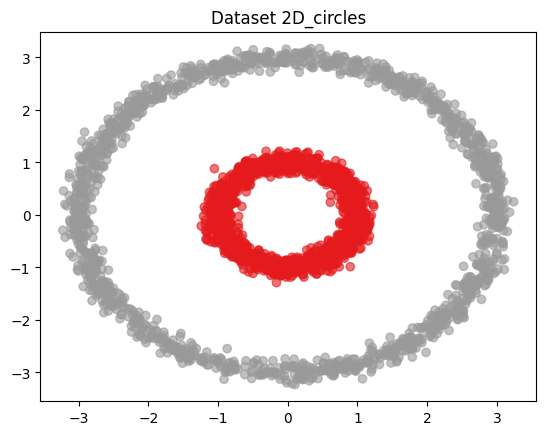

In [60]:
df = datasets["2D_circles"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 2D_circles")
plt.show()

In [61]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["2D_circles"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["2D_circles"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [62]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.0,0.0,0.0,0.0,0.0
120,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0


In [63]:
# plot_hierarchical_quivers_with_complexity(
#     data_clusters,
#     centroids_dict,
#     host_instance_by_layer_df,
#     delta=0.5,
#     k_auto=4)
# solo toma el valor 0

In [64]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: 0.0, 1: 0.0},
 'normalized_simple': {0: 0.0, 1: 0.0},
 'robust': {0: 0.0, 1: 0.0},
 'norm_by_movement': {0: 0.0, 1: 0.0},
 'robust_norm_by_movement': {0: 0.0, 1: 0.0}}

In [65]:
resultados

{'scores': {'raw': {0: 0.0, 1: 0.0},
  'normalized_simple': {0: 0.0, 1: 0.0},
  'robust': {0: 0.0, 1: 0.0},
  'norm_by_movement': {0: 0.0, 1: 0.0},
  'robust_norm_by_movement': {0: 0.0, 1: 0.0}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [0, 1],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([0., 0.]), array([0., 0.]), array([0., 0.])],
 'list_scores_robust': [array([0., 0.]), array([0., 0.]), array([0., 0.])],
 'list_scores_centroid_mean_range': [array([0.26854998, 0.31487145]),
  array([0.28516984, 0.3678828 ]),
  array([0.41990783, 0.45307734])],
 'list_scores_centroid_sum_range': [array([161.12998765, 188.92287059]),
  array([34.22038099, 44.14593631]),
  array([10.07778801, 10.87385617])],
 'list_scores_centroid_mean_iqr': [array([1.10032513, 1.01719548]),
  array([0.85980302, 1.07824664]),
  array([0.88611985, 0.99283093])],
 'list_scores_centroid_sum_iqr': [array([660.19507509, 610.31728514]),
  array(

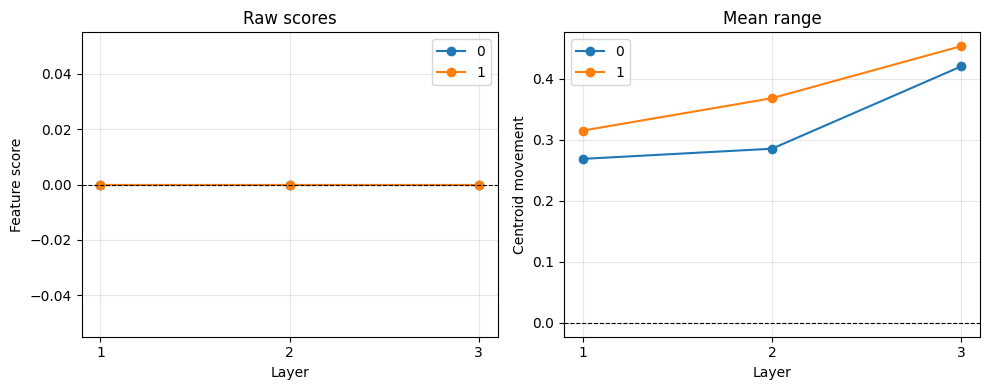

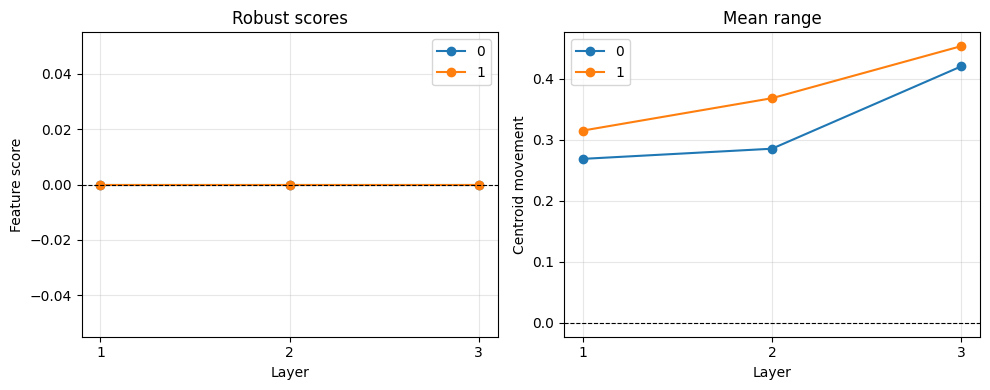

In [66]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [67]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0


Centroids movement


layer,1,2,3
feature,,,
0,0.268550,0.285170,0.419908
1,0.314871,0.367883,0.453077


Se aprecia que las dos variables son importantes.

## Dataset 8: Cruz de elipses (misma media, distinta varianza)

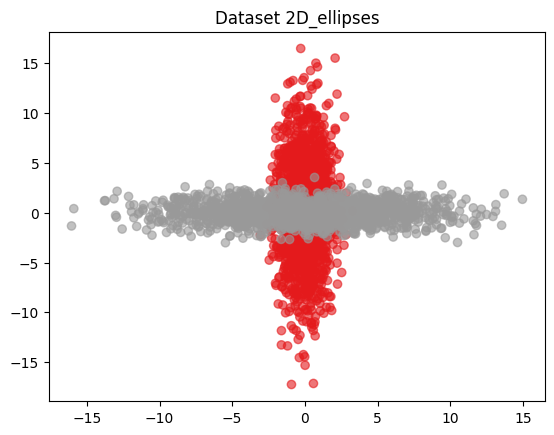

In [68]:
df = datasets["2D_ellipses"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 2D_ellipses")
plt.show()

In [69]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["2D_ellipses"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["2D_ellipses"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [70]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.372667,0.372667,0.103333,0.136667,0.120000
120,0.486000,0.502000,0.087333,0.137333,0.112333
24,0.681333,0.643333,0.112000,0.124000,0.118000
4,1.000000,0.766667,0.084000,0.150667,0.117333


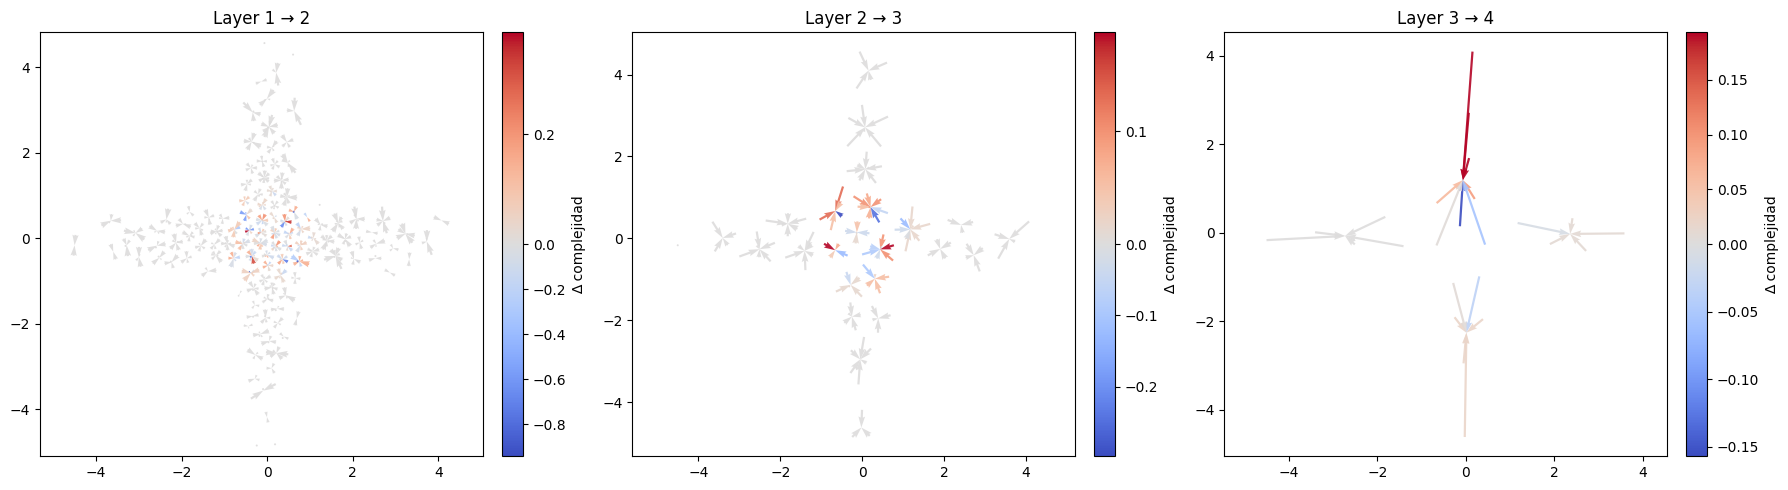

In [71]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

Vemos que alejarnos del centro minimiza la complejidad y acercarnos al centro la aumenta.

In [72]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=4)
resultados['scores']

{'raw': {0: -0.05618919440948045, 1: 0.8598828771103911},
 'normalized_simple': {0: -0.06133708924916349, 1: 0.9386629107508365},
 'robust': {0: -0.0750980910709337, 1: -39.654314937464115},
 'norm_by_movement': {0: -0.0006430270907779711, 1: 0.008921094973239407},
 'robust_norm_by_movement': {0: -3.473920526817244e-05,
  1: -0.012119808089424403}}

In [73]:
resultados

{'scores': {'raw': {0: -0.05618919440948045, 1: 0.8598828771103911},
  'normalized_simple': {0: -0.06133708924916349, 1: 0.9386629107508365},
  'robust': {0: -0.0750980910709337, 1: -39.654314937464115},
  'norm_by_movement': {0: -0.0006430270907779711, 1: 0.008921094973239407},
  'robust_norm_by_movement': {0: -3.473920526817244e-05,
   1: -0.012119808089424403}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [1, 0],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [1, 0]},
 'list_scores_raw': [array([-0.29394373, -0.16330765]),
  array([0.09747135, 0.18733664]),
  array([0.14028319, 0.83585388])],
 'list_scores_robust': [array([-4.24396439, -1.85672761]),
  array([-1.16793125,  9.42011378]),
  array([  5.26169945, -86.87201605])],
 'list_scores_centroid_mean_range': [array([0.28909939, 0.2530639 ]),
  array([0.36883027, 0.36864174]),
  array([0.2887404 , 0.26230368])],
 'list_scores_centroid_sum_range': [array([173.45963665, 151.83833859]),
  array

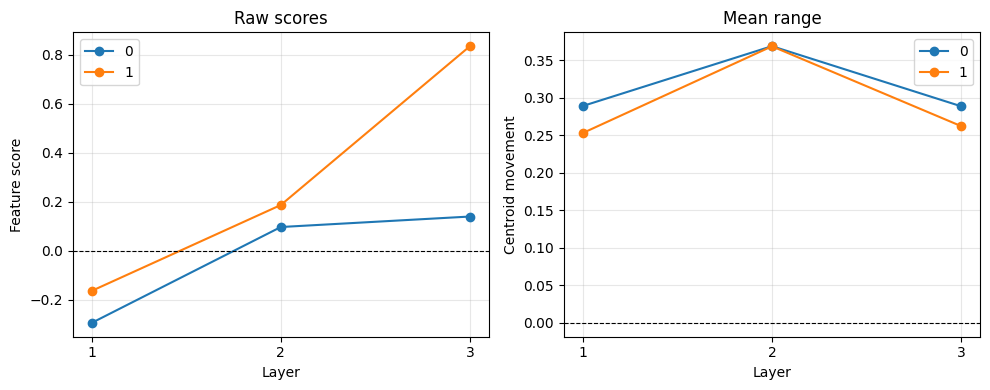

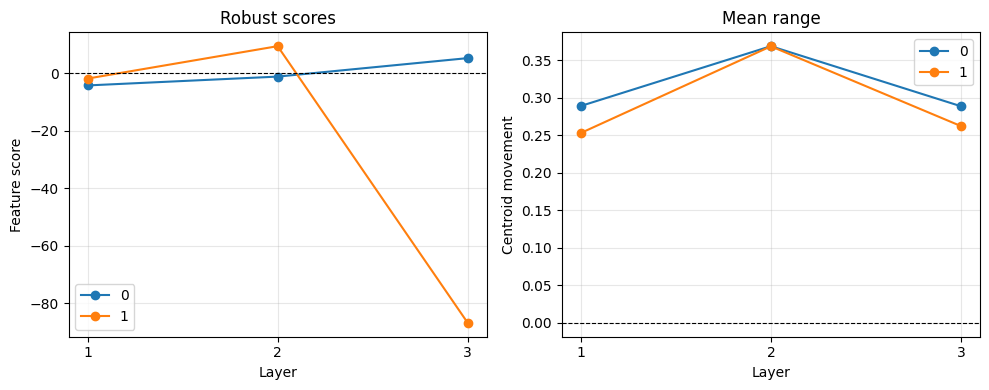

In [74]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [75]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,-0.293944,0.097471,0.140283
1,-0.163308,0.187337,0.835854


Centroids movement


layer,1,2,3
feature,,,
0,0.289099,0.368830,0.288740
1,0.253064,0.368642,0.262304


El movimiento de los centroides lo veo bien, sí refleja que ambas variables son importantes (tiran de los clusters). El problema es la complejidad en las capas finales. También es esperable puesto que depende de la inicialización de los clusters y de cómo vaya evolucionando. A lo mejor hay que limitar a 1 sola transición o usar un sigma más pequeño para ir agrupando de menos en menos.

## Dataset 9 Clusters con distinto tamaño

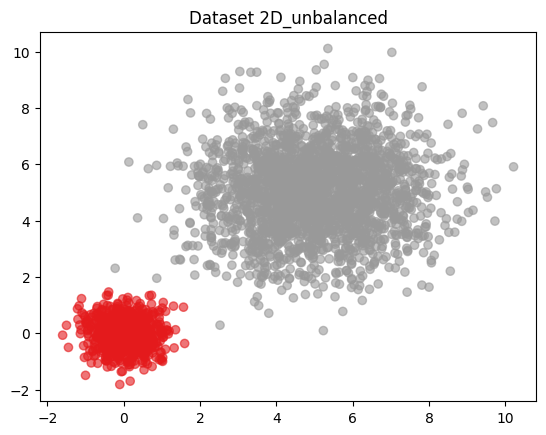

In [76]:
df = datasets["2D_unbalanced"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 2D_unbalanced")
plt.show()

In [77]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["2D_unbalanced"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["2D_unbalanced"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [78]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.000000,0.000000,0.0,0.0,0.0
120,0.000000,0.000000,0.0,0.0,0.0
24,0.038667,0.000444,0.0,0.0,0.0
4,1.000000,0.001333,0.0,0.0,0.0


In [79]:
# plot_hierarchical_quivers_with_complexity(
#     data_clusters,
#     centroids_dict,
#     host_instance_by_layer_df,
#     delta=0.5,
#     k_auto=4)

In [80]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=k_auto)
resultados['scores']

{'raw': {0: 0.0, 1: 0.0},
 'normalized_simple': {0: 0.0, 1: 0.0},
 'robust': {0: 0.0, 1: 0.0},
 'norm_by_movement': {0: 0.0, 1: 0.0},
 'robust_norm_by_movement': {0: 0.0, 1: 0.0}}

In [81]:
resultados

{'scores': {'raw': {0: 0.0, 1: 0.0},
  'normalized_simple': {0: 0.0, 1: 0.0},
  'robust': {0: 0.0, 1: 0.0},
  'norm_by_movement': {0: 0.0, 1: 0.0},
  'robust_norm_by_movement': {0: 0.0, 1: 0.0}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [0, 1],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([0., 0.]), array([0., 0.]), array([0., 0.])],
 'list_scores_robust': [array([0., 0.]), array([0., 0.]), array([0., 0.])],
 'list_scores_centroid_mean_range': [array([0.31600446, 0.30140238]),
  array([0.35288311, 0.37542432]),
  array([0.48995769, 0.46211689])],
 'list_scores_centroid_sum_range': [array([189.60267602, 180.8414268 ]),
  array([42.34597344, 45.05091861]),
  array([11.75898465, 11.09080547])],
 'list_scores_centroid_mean_iqr': [array([1.02975022, 0.94082026]),
  array([0.99506787, 0.98605728]),
  array([1.02166104, 1.07085713])],
 'list_scores_centroid_sum_iqr': [array([617.85013044, 564.49215734]),
  array(

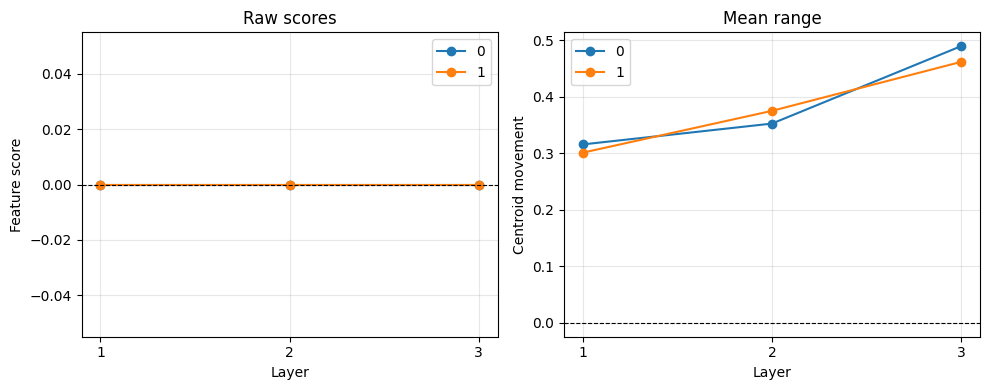

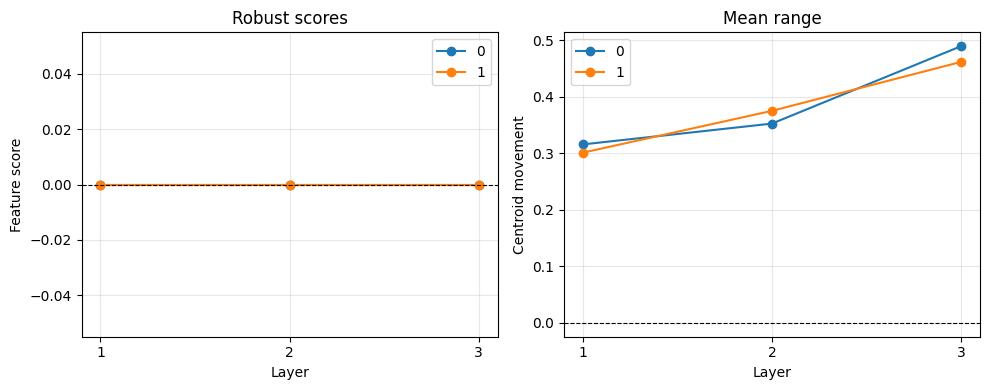

In [82]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [83]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,0.0,0.0,0.0
1,0.0,0.0,0.0


Centroids movement


layer,1,2,3
feature,,,
0,0.316004,0.352883,0.489958
1,0.301402,0.375424,0.462117


Indica que todo aporta igual

## Dataset 10 Aleatorio

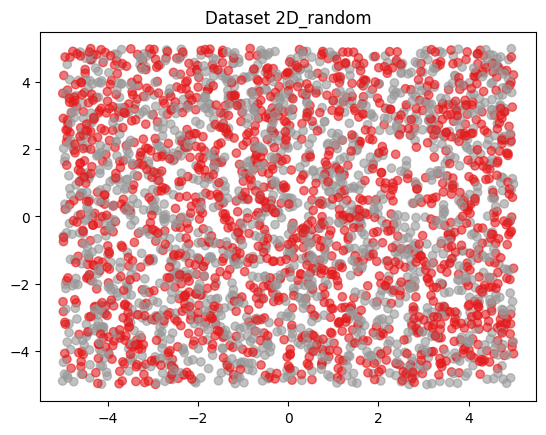

In [84]:
df = datasets["2D_random"]
plt.scatter(df["0"], df["1"], c=df["label"], cmap="Set1", alpha=0.6)
plt.title("Dataset 2D_random")
plt.show()

In [85]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = datasets["2D_random"].iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = datasets["2D_random"]['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(4)

In [86]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.89397,0.932931,0.402916,0.396378,0.399667
120,1.00000,1.000000,0.339298,0.338028,0.338667
24,1.00000,1.000000,0.324056,0.344735,0.334333
4,1.00000,1.000000,0.328032,0.342723,0.335333


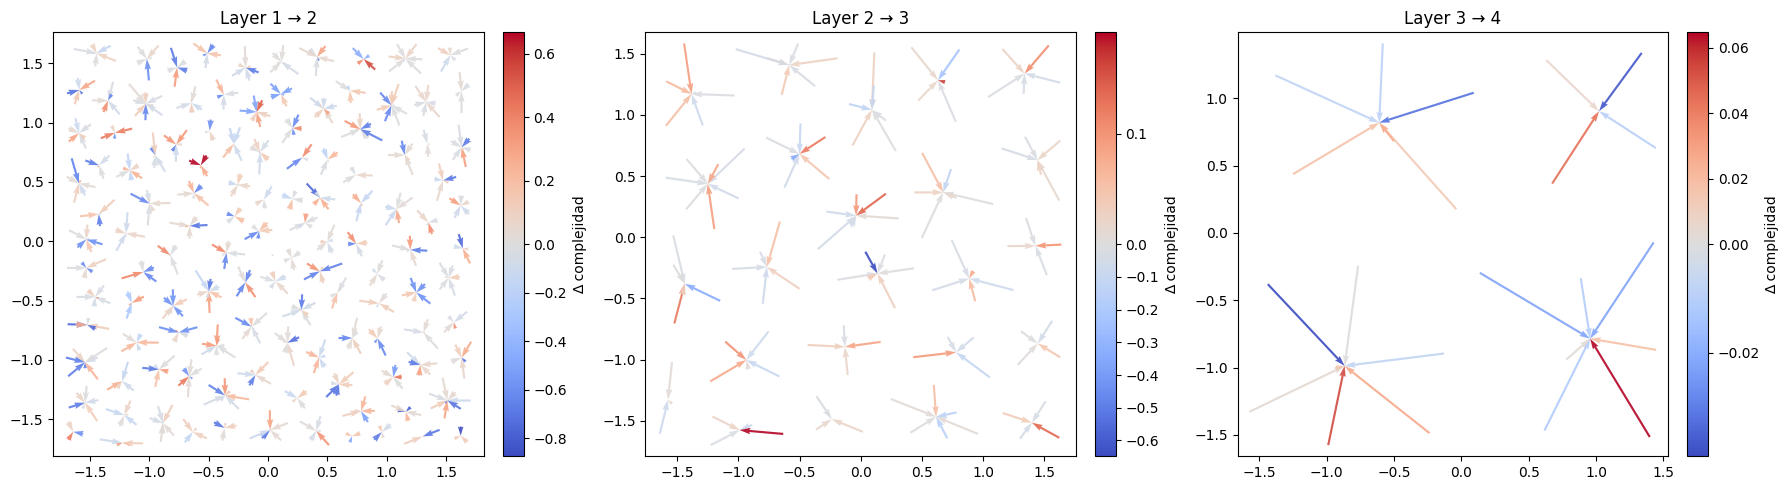

In [87]:
plot_hierarchical_quivers_with_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    k_auto=4)

In [88]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=k_auto)
resultados['scores']

{'raw': {0: -2.812752053313234, 1: -2.3514212310121985},
 'normalized_simple': {0: -0.5446664738866617, 1: -0.4553335261133383},
 'robust': {0: -20.103256159551293, 1: -11.335309734012858},
 'norm_by_movement': {0: -0.038953504720781046, 1: -0.032264792391801585},
 'robust_norm_by_movement': {0: -0.01017563104479432,
  1: -0.005745682617949768}}

In [89]:
resultados

{'scores': {'raw': {0: -2.812752053313234, 1: -2.3514212310121985},
  'normalized_simple': {0: -0.5446664738866617, 1: -0.4553335261133383},
  'robust': {0: -20.103256159551293, 1: -11.335309734012858},
  'norm_by_movement': {0: -0.038953504720781046, 1: -0.032264792391801585},
  'robust_norm_by_movement': {0: -0.01017563104479432,
   1: -0.005745682617949768}},
 'rankings': {'raw': [0, 1],
  'normalized_simple': [0, 1],
  'robust': [0, 1],
  'norm_by_movement': [0, 1],
  'robust_norm_by_movement': [0, 1]},
 'list_scores_raw': [array([-2.68289636, -2.20787222]),
  array([-0.12776661, -0.18641978]),
  array([-0.00208908,  0.04287077])],
 'list_scores_robust': [array([-29.4490847 , -24.70676057]),
  array([-4.88395684, -1.03916835]),
  array([-5.87347078,  3.07530945])],
 'list_scores_centroid_mean_range': [array([0.34254277, 0.34124718]),
  array([0.3936731 , 0.34569918]),
  array([0.52807341, 0.57934354])],
 'list_scores_centroid_sum_range': [array([205.52566179, 204.74830748]),
  arra

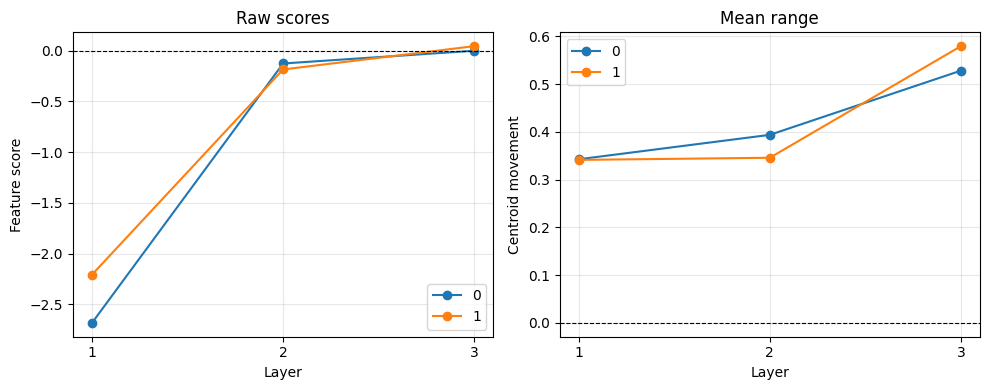

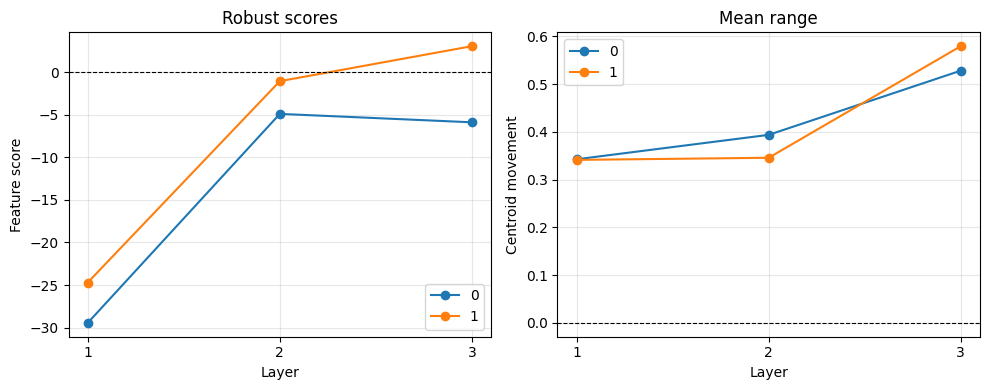

In [90]:
feature_cols = ["0", "1"]
plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [91]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1,2,3
feature,,,
0,-2.682896,-0.127767,-0.002089
1,-2.207872,-0.186420,0.042871


Centroids movement


layer,1,2,3
feature,,,
0,0.342543,0.393673,0.528073
1,0.341247,0.345699,0.579344


Esto despista un poco, básicamente las 2 variables son igual de importantes y parece que minimizan la complejidad pero en realidad no. Lo bueno es que no le dan prioridad a ninguna y eso está bien.

Quizás norm_by_movment es mejor, pero tampoco me encaja del todo. Necesito crear casos artificiales con más variables porque al final es lo que quiero detectar, lo que sobra. Con estos ejemplos, al final me estoy centrando más en: de lo que es necesario, qué es mejor? Y eso tampoco es la prioridad

## Ejemplos artificiales con variables sobrantes

Vamos a usar la opción de python sklearn.datasets.make_classification que permite definir el número total de features, cuántas de dichas variables son realmente informativas, cuántas redundantes (combinaciones lineales de otras) y cuántas son totalmente ruido (n_noise=n_features−n_informative−n_redundant−n_repeated).

### Variables informativas + variables copiadas

In [136]:
n_features = 30
n_informative = 20
X, y = make_classification(
    n_samples=3000,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=0,
    n_repeated=10,
    n_classes=2,
    random_state=42
)

feature_cols = [i for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_cols)
df["label"] = y

In [137]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(120)

In [138]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.277333,0.298000,0.066667,0.054,0.060333
120,0.692000,0.806667,0.078667,0.048,0.063333
24,0.966667,0.998000,0.108667,0.052,0.080333
4,0.998000,1.000000,0.111333,0.048,0.079667


In [139]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=k_auto)
resultados['scores']

{'raw': {0: 2.2899835562987496,
  1: 3.506587956936114,
  2: 4.475100669875852,
  3: 2.9562022434282453,
  4: 3.9317548176464054,
  5: 2.7698665914614695,
  6: 4.121564177888257,
  7: 3.606729439750405,
  8: 4.022504353437523,
  9: 3.0963242663414583,
  10: 2.9266758056181965,
  11: 4.022504353437523,
  12: 4.54327637344048,
  13: 3.905954677389041,
  14: 2.9562022434282453,
  15: 3.9626233508058655,
  16: 3.109861183878702,
  17: 3.488439781071119,
  18: 2.9266758056181965,
  19: 3.9094171564346643,
  20: 3.0963242663414583,
  21: 3.606729439750405,
  22: 2.7698665914614695,
  23: 4.022504353437523,
  24: 4.160590226479681,
  25: 3.367961591837112,
  26: 4.54327637344048,
  27: 4.54327637344048,
  28: 3.333320373936374,
  29: 2.9562022434282453},
 'normalized_simple': {0: 0.021416066117584148,
  1: 0.03279382479682356,
  2: 0.041851414856362075,
  3: 0.027646583980077487,
  4: 0.03677001125236918,
  5: 0.025903961579315144,
  6: 0.038545119985134914,
  7: 0.03373035406192016,
  8: 0.0

In [140]:
resultados

{'scores': {'raw': {0: 2.2899835562987496,
   1: 3.506587956936114,
   2: 4.475100669875852,
   3: 2.9562022434282453,
   4: 3.9317548176464054,
   5: 2.7698665914614695,
   6: 4.121564177888257,
   7: 3.606729439750405,
   8: 4.022504353437523,
   9: 3.0963242663414583,
   10: 2.9266758056181965,
   11: 4.022504353437523,
   12: 4.54327637344048,
   13: 3.905954677389041,
   14: 2.9562022434282453,
   15: 3.9626233508058655,
   16: 3.109861183878702,
   17: 3.488439781071119,
   18: 2.9266758056181965,
   19: 3.9094171564346643,
   20: 3.0963242663414583,
   21: 3.606729439750405,
   22: 2.7698665914614695,
   23: 4.022504353437523,
   24: 4.160590226479681,
   25: 3.367961591837112,
   26: 4.54327637344048,
   27: 4.54327637344048,
   28: 3.333320373936374,
   29: 2.9562022434282453},
  'normalized_simple': {0: 0.021416066117584148,
   1: 0.03279382479682356,
   2: 0.041851414856362075,
   3: 0.027646583980077487,
   4: 0.03677001125236918,
   5: 0.025903961579315144,
   6: 0.0385451

In [142]:
#feature_cols = df.columns[:-1]
# plot_scores_by_layer(resultados['list_scores_raw'],resultados['list_scores_centroid_mean_range'], feature_cols, title1='Raw scores', title2='Mean range')
# plot_scores_by_layer(resultados['list_scores_robust'],resultados['list_scores_centroid_mean_range'], feature_cols,title1='Robust scores', title2='Mean range')

In [143]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1
feature,
0,2.289984
1,3.506588
2,4.475101
3,2.956202
4,3.931755
5,2.769867
6,4.121564
7,3.606729
8,4.022504


Centroids movement


layer,1
feature,
0,0.256934
1,0.201450
2,0.203875
3,0.233549
4,0.180285
5,0.181444
6,0.202104
7,0.219313
8,0.257382


In [146]:
df_centroids_wide.drop_duplicates()

layer,1
feature,
0,0.256934
1,0.201450
2,0.203875
3,0.233549
4,0.180285
5,0.181444
6,0.202104
7,0.219313
8,0.257382


In [148]:
df_complexity_wide.drop_duplicates()

layer,1
feature,
0,2.289984
1,3.506588
2,4.475101
3,2.956202
4,3.931755
5,2.769867
6,4.121564
7,3.606729
8,4.022504


Las que son exactamente iguales, las detecta porque son duplicados tanto en el movimiento de los centroides como en el score que también contempla la complejidad.

In [150]:
#Revisamos rankings
ranking_raw = resultados["rankings"]["raw"]
ranking_cent = resultados["rankings_centroid"]["cent_mean_range"]

print("Ranking por complejidad (raw):", ranking_raw)
print("Ranking por centroides (mean_range):", ranking_cent)



Ranking por complejidad (raw): [0, 5, 22, 10, 18, 3, 14, 29, 9, 20, 16, 28, 25, 17, 1, 7, 21, 13, 19, 4, 15, 8, 11, 23, 6, 24, 2, 12, 26, 27]
Ranking por centroides (mean_range): [13, 8, 11, 23, 0, 10, 18, 3, 14, 29, 16, 15, 7, 21, 28, 25, 24, 19, 2, 6, 1, 12, 26, 27, 17, 9, 20, 5, 22, 4]


Claramente hay que analizar el ranking después de quitar duplicados.

### Variables informativas + variables combinación lineal

In [154]:
n_features = 30
n_informative = 15
X, y = make_classification(
    n_samples=3000,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=15,
    n_repeated=0,
    n_classes=2,
    random_state=42
)

feature_cols = [i for i in range(n_features)]
df = pd.DataFrame(X, columns=feature_cols)
df["label"] = y

In [155]:
sigma = 5
delta = 0.5
seed = 0
k_min = 0
X = df.iloc[:,:-1].to_numpy() # all variables except y
X = preprocessing.scale(X)
y = df['label'].to_numpy()
host_instance_by_layer_df, data_clusters, centroids_dict, results, k_auto = hostility_measure_Centroids(sigma, X, y, delta, k_min, seed=0)
k_auto

np.int64(120)

In [156]:
results

,Overlap_0,Overlap_1,Host_0,Host_1,Dataset_Host
600,0.289439,0.224734,0.059492,0.072473,0.066000
120,0.747995,0.683511,0.049465,0.077128,0.063333
24,0.946524,0.982048,0.073529,0.091755,0.082667
4,1.000000,0.997340,0.064171,0.097074,0.080667


In [157]:
resultados = rank_features_by_centroid_complexity(
    data_clusters,
    centroids_dict,
    host_instance_by_layer_df,
    delta=0.5,
    cluster_prefix='cluster_',
    k_auto=k_auto)
resultados['scores']

{'raw': {0: -0.9672819906337373,
  1: -1.8958561823924123,
  2: 0.3784584201416802,
  3: -1.1466069558692187,
  4: -0.05635529076837354,
  5: -0.4271269297499158,
  6: 0.8531214055699895,
  7: -1.6611821115636527,
  8: 0.7670320333713955,
  9: -0.37491895630229555,
  10: 0.7707756364998095,
  11: -0.619982846102648,
  12: -0.6157781057829969,
  13: -0.16776017560684342,
  14: 1.0689048982624536,
  15: -0.42594879191721424,
  16: 0.24934989585017997,
  17: 2.884558319590259,
  18: -0.2814106854960544,
  19: 1.539812587005439,
  20: 1.728832546385994,
  21: 1.0995230771986555,
  22: 0.3432099732348713,
  23: 0.8019505432381505,
  24: -0.05117443443860855,
  25: 0.7845668324431668,
  26: -0.1875111889905896,
  27: 2.0604816199572085,
  28: -0.3613465295256893,
  29: -2.0364011562779507},
 'normalized_simple': {0: -0.036354116900042754,
  1: -0.07125344826817934,
  2: 0.014223899318772514,
  3: -0.04309382756600438,
  4: -0.002118045046188721,
  5: -0.016053046046180776,
  6: 0.03206353018

In [158]:
df_long, df_complexity_wide, df_centroids_wide = scores_tables_by_layer(
    resultados['list_scores_raw'],        # complejidad
    resultados['list_scores_centroid_mean_range'],  # movimiento centroides
    feature_cols
)

print('Complexity')
display(df_complexity_wide)
print('Centroids movement')
display(df_centroids_wide)

Complexity


layer,1
feature,
0,-0.967282
1,-1.895856
2,0.378458
3,-1.146607
4,-0.056355
5,-0.427127
6,0.853121
7,-1.661182
8,0.767032


Centroids movement


layer,1
feature,
0,0.212192
1,0.231090
2,0.221867
3,0.234609
4,0.246803
5,0.228753
6,0.223281
7,0.182429
8,0.190397


In [159]:
df_centroids_wide

layer,1
feature,
0,0.212192
1,0.231090
2,0.221867
3,0.234609
4,0.246803
5,0.228753
6,0.223281
7,0.182429
8,0.190397


In [160]:
df_centroids_wide.drop_duplicates()

layer,1
feature,
0,0.212192
1,0.231090
2,0.221867
3,0.234609
4,0.246803
5,0.228753
6,0.223281
7,0.182429
8,0.190397


In [161]:
informative_features = [i for i in range(n_informative)]
df_eval = pd.DataFrame({
    "feature": feature_cols,
    "rank_raw": [ranking_raw.index(f) for f in feature_cols],
    "rank_centroid": [ranking_cent.index(f) for f in feature_cols],
    "is_informative": [f in informative_features for f in feature_cols]
})

In [162]:

# Ordenamos por ranking_raw
df_eval_sorted = df_eval.sort_values("rank_raw").reset_index(drop=True)

# Mostrar primeras filas
display(df_eval_sorted)



,feature,rank_raw,rank_centroid,is_informative
0,0,0,4,True
1,5,1,27,True
2,22,2,28,False
3,10,3,5,True
4,18,4,6,False
5,3,5,7,True
6,14,6,8,True
7,29,7,9,False
8,9,8,25,True
9,20,9,26,False


Numéricamente no podemos ver que 1 variable es combinación lineal de otras (ni sabemos si justo esa combinación es mejor que las originales). Para eso ya tenemos que sacar medidas de rendimiento antes y después, esa es la verdadera comparativa. Varias cosas:

  - Los resultados van a depender de la medida de rendimiento. Sugiero coger GPS como medida global para analizar si se pilla correctamente la estructura del dataset y no solo ir a accuracy.
  - Tengo que sacar valores de la hostilidad antes y después de quitar variables para saber un poco qué esperar. Es decir, tengo que comprobar que realmente el hecho de quitar variables ruidosas o redundantes minimiza la hostilidad.
  - El enfoque local de dar pesos a las features por cada clase también lo veo interesante aunque quizás sea meterse un poco en mundo imbalanced.
  - También podemos hacer una combinación de "primero una medida para limpiar y luego otra"
  - Si quiero estudiar correlación entre el movimiento de las variables, tengo que usar un sigma más chiquitín o sacar la info de la propia ejecución de las k-medias. O mirar si vuelvo a la versión weighted de R.

